# NNets (cont'd), TensorFlow, Keras etc.
# Pandas - intro

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [62]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Y_train = mnist.train.labels
Y_test  = mnist.test.labels

def one_hot_encode(t):
    R = np.zeros((len(t), np.max(t)+1))
    R[np.arange(len(t)), t] = 1.0
    return R

def one_hot_decode(R):
    return np.argmax(R, axis=1)


def softmax(y):
    "for each row in y, denoted as y_row, compute normalized(exp(y_row))"
    y = np.exp(y)
    return y / np.sum(y, axis=1).reshape(-1,1)

def nnet(X, W):
    return softmax(X.dot(W))

Y_train2 = one_hot_encode(Y_train)
Y_test2  = one_hot_encode(Y_test)
np.random.seed(123)
X_train = np.insert(mnist.train.images, 0, 1.0, axis=1) # add a column of ones
X_test  = np.insert(mnist.test.images, 0, 1.0, axis=1)  # add a column of ones
W = np.zeros(shape=(785, 10))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [63]:
def accuracy(W, X, Y):
    # Y = vector of labels
    return np.mean(one_hot_decode(nnet(X, W)) == Y)

def cross_entropy(W, X, Y):
    # Y = one-hot
    Y_pred = nnet(X, W)
    return -np.sum(Y * np.log(Y_pred))/X.shape[0]

In [64]:
accuracy(W, X_train, Y_train)

0.098981818181818185

In [65]:
cross_entropy(W, X_train, Y_train2)

2.3025850929940432

In [66]:
import scipy.optimize

In [67]:
# error = lambda w: cross_entropy(w.reshape(785,10), X_train, Y_train2)

# res = scipy.optimize.minimize(error, W.ravel(), method='Nelder-Mead',
#                              options=dict(disp=True))

In [68]:
def cross_entropy_grad(W, X, Y):
    return -(X.T @ (Y - nnet(X, W)))/X.shape[0]

In [69]:
#cross_entropy_grad(W, X_train, Y_train2)
# gradient descent
W = np.zeros(shape=(785, 10)) # starting point
eta = 0.5 # learning rate / step size
i = 1
while True:
    grad = cross_entropy_grad(W, X_train, Y_train2)
    W = W - eta*grad
    
    print("%4d: cross_entropy=%.6f accuracy=%.6f accuract_test=%.6f" %
         (i, cross_entropy(W, X_train, Y_train2),
         accuracy(W, X_train, Y_train),
         accuracy(W, X_test, Y_test)))
    if np.sum(grad**2) < 1e-6: break # Euclidean norm
    i += 1


   1: cross_entropy=1.832930 accuracy=0.662927 accuract_test=0.670500
   2: cross_entropy=1.515830 accuracy=0.777473 accuract_test=0.790200
   3: cross_entropy=1.303822 accuracy=0.772745 accuract_test=0.784000
   4: cross_entropy=1.157700 accuracy=0.805764 accuract_test=0.815600


KeyboardInterrupt: 

In [70]:
#cross_entropy_grad(W, X_train, Y_train2)
# mini-batch gradient descent
W = np.zeros(shape=(785, 10)) # starting point
eta = 0.5 # learning rate / step size
splitnum = 100
s = X_train.shape[0]//splitnum # batch size
maxiter = 100
np.random.seed(123)

for i in range(maxiter):
    idx = np.random.permutation(np.arange(X_train.shape[0]))
    for j in range(splitnum):
        sample = idx[j*s:(j+1)*s]
        grad = cross_entropy_grad(W, X_train[sample,:], Y_train2[sample])
        W = W - eta*grad
    
    print("%4d: cross_entropy=%.6f accuracy=%.6f accuract_test=%.6f grad=%.6f" %
         (i+1, cross_entropy(W, X_train, Y_train2),
         accuracy(W, X_train, Y_train),
         accuracy(W, X_test, Y_test),
         np.sum(grad**2)))


   1: cross_entropy=0.397411 accuracy=0.892564 accuract_test=0.901200 grad=0.028347
   2: cross_entropy=0.349747 accuracy=0.902218 accuract_test=0.909500 grad=0.017932
   3: cross_entropy=0.329111 accuracy=0.908509 accuract_test=0.913200 grad=0.026719
   4: cross_entropy=0.317361 accuracy=0.911527 accuract_test=0.916800 grad=0.032238
   5: cross_entropy=0.308852 accuracy=0.914091 accuract_test=0.919400 grad=0.026180
   6: cross_entropy=0.301318 accuracy=0.916218 accuract_test=0.919000 grad=0.025399
   7: cross_entropy=0.298342 accuracy=0.916891 accuract_test=0.920700 grad=0.033075
   8: cross_entropy=0.292492 accuracy=0.919145 accuract_test=0.919400 grad=0.018812
   9: cross_entropy=0.289134 accuracy=0.919709 accuract_test=0.921300 grad=0.018522
  10: cross_entropy=0.286485 accuracy=0.920418 accuract_test=0.921100 grad=0.029291
  11: cross_entropy=0.283321 accuracy=0.921127 accuract_test=0.921600 grad=0.018598
  12: cross_entropy=0.281077 accuracy=0.922018 accuract_test=0.921800 grad=0

```python
def mini_batch_gd_optimizer(W_start, ...):
    # ...
    return (cross_entropy(W_final), W_final)
    
bestW = None
bestE = np.Inf
for i in range(number_of_restarts):
    W = generate_random_W()
    curE, curW = mini_batch_gd_optimizer(W, ...)
    if curE < bestE:
        bestE = curE
        bestW = curW
        
return bestW
```

# The same, but with TensorFlow

In [71]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 785])
y = tf.placeholder(tf.float32, [None, 10])
W = tf.Variable(tf.zeros([785, 10]))
ypred = tf.nn.softmax(tf.matmul(x, W))
cross_entropy = -tf.reduce_sum(y * tf.log(ypred))/tf.cast(tf.shape(y), tf.float32)[0]
accuracy = tf.reduce_mean(
        tf.cast(tf.equal(tf.argmax(ypred, 1), tf.argmax(y, 1)), tf.float32)
)
#train_step = W-eta*cross_etropy_grad
eta = 0.5
train_step = tf.train.GradientDescentOptimizer(eta).minimize(cross_entropy)

In [72]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

np.random.seed(123)
splitnum = 100
s = X_train.shape[0]//splitnum # batch size
maxiter = 100
for i in range(maxiter):
    idx = np.random.permutation(np.arange(X_train.shape[0]))
    for j in range(splitnum):
        sample = idx[j*s:(j+1)*s]
        #grad = cross_entropy_grad(W, X_train[sample,:], Y_train2[sample])
        #W = W - eta*grad
        sess.run(train_step,
                feed_dict={
                        x: X_train[sample,:],
                        y: Y_train2[sample,:]
                }
                )
    
    ac = sess.run(accuracy, feed_dict={x: X_train, y: Y_train2})
    print("%4d: accuracy=%.6f" %
         (i+1, ac))


   1: accuracy=0.892564
   2: accuracy=0.902218
   3: accuracy=0.908509
   4: accuracy=0.911527
   5: accuracy=0.914091
   6: accuracy=0.916218
   7: accuracy=0.916891
   8: accuracy=0.919145
   9: accuracy=0.919709
  10: accuracy=0.920418
  11: accuracy=0.921127
  12: accuracy=0.922018
  13: accuracy=0.923073
  14: accuracy=0.922836
  15: accuracy=0.921745
  16: accuracy=0.923091
  17: accuracy=0.923218
  18: accuracy=0.924873
  19: accuracy=0.925127
  20: accuracy=0.924855
  21: accuracy=0.925473
  22: accuracy=0.925873
  23: accuracy=0.926309
  24: accuracy=0.926491
  25: accuracy=0.926691
  26: accuracy=0.926945
  27: accuracy=0.926982
  28: accuracy=0.927327
  29: accuracy=0.927073
  30: accuracy=0.927291
  31: accuracy=0.927491
  32: accuracy=0.927418
  33: accuracy=0.928127
  34: accuracy=0.927745
  35: accuracy=0.927982
  36: accuracy=0.928418
  37: accuracy=0.928691
  38: accuracy=0.928636
  39: accuracy=0.929291
  40: accuracy=0.928873
  41: accuracy=0.929273
  42: accuracy=0

# The same, but with Keras

In [73]:
import keras

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential()
model.add(Dense(10, input_dim=785))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy',
             optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, Y_train2, epochs=5, batch_size=100, verbose=1)


Epoch 1/5
55000/55000 [==============================] - 1s 20us/step - loss: 1.2187 - acc: 0.7115
Epoch 2/5
55000/55000 [==============================] - 1s 18us/step - loss: 0.6752 - acc: 0.8460
Epoch 3/5
55000/55000 [==============================] - 1s 18us/step - loss: 0.5577 - acc: 0.8631
Epoch 4/5
55000/55000 [==============================] - 1s 17us/step - loss: 0.5016 - acc: 0.8721
Epoch 5/5
55000/55000 [==============================] - 1s 17us/step - loss: 0.4672 - acc: 0.8781


# Pandas

> 80% of data analysis is spent on the process of cleaning and preparing the data (Dasu&Johnson, 2003)

Pandas comes with 3 main classes:

* Series - wrapper around numpy vectors, represents columns(variables) in a data frame
* Index - similar to Series, used to store row/column labels
* DataFrame - sequence/dictionary of Series objects of identical lengths

In [80]:
import pandas as pd
pd.set_option("display.notebook_repr_html", False)

In [81]:
np.random.seed(123)
x = pd.DataFrame({ # dictionary
    "A": np.round(np.random.uniform(0, 1, 5), 2),
    "B": np.random.choice([True,False], 5, [0.4, 0.6]),
    "C": ["f", None, "f", "m", "f"]
})
x

      A      B     C
0  0.70  False     f
1  0.29  False  None
2  0.23   True     f
3  0.55  False     m
4  0.72   True     f

In [84]:
pd.DataFrame(
    np.arange(12).reshape(4,3),
    columns = ["a", "b", "c"],
    index = ["x", "y", "z", "w"]
)

   a   b   c
x  0   1   2
y  3   4   5
z  6   7   8
w  9  10  11

In [85]:
p = [
    ("a", np.r_[1,2,3]),
    ("b", [True, False, True]),
    ("c", ["aaa", "bbb", "ccc"])
]

In [87]:
pd.DataFrame(p)

   0                    1
0  a            [1, 2, 3]
1  b  [True, False, True]
2  c      [aaa, bbb, ccc]

In [89]:
pd.DataFrame.from_items(p)

   a      b    c
0  1   True  aaa
1  2  False  bbb
2  3   True  ccc

In [90]:
birth_dates = pd.read_csv("http://www.gagolewski.com/resources/data/birth_dates.csv",
                          comment="#")
birth_dates.head()

               Name   BirthDate
0    Hung Hyun-Seok  12.06.2000
1  Benno Blumenthal  31.12.1918
2  Paitoon Ornwimol  26.06.1958
3    P'yon Yong-Sun  10.07.1947
4    Étienne Chaney  04.09.1983

In [91]:
x

      A      B     C
0  0.70  False     f
1  0.29  False  None
2  0.23   True     f
3  0.55  False     m
4  0.72   True     f

In [92]:
x.shape

(5, 3)

In [93]:
len(x)

5

In [94]:
x.head(2)

      A      B     C
0  0.70  False     f
1  0.29  False  None

In [95]:
x.tail(2)

      A      B  C
3  0.55  False  m
4  0.72   True  f

In [96]:
x.dtypes

A    float64
B       bool
C     object
dtype: object

In [97]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
A    5 non-null float64
B    5 non-null bool
C    4 non-null object
dtypes: bool(1), float64(1), object(1)
memory usage: 165.0+ bytes


# Series

In [98]:
x["A"]

0    0.70
1    0.29
2    0.23
3    0.55
4    0.72
Name: A, dtype: float64

In [99]:
type(x["A"])

pandas.core.series.Series

In [100]:
pd.DataFrame(x["A"])

      A
0  0.70
1  0.29
2  0.23
3  0.55
4  0.72

In [101]:
x.get("A")

0    0.70
1    0.29
2    0.23
3    0.55
4    0.72
Name: A, dtype: float64

In [103]:
x.loc[:,"A"] # THE THE THE preferred way

0    0.70
1    0.29
2    0.23
3    0.55
4    0.72
Name: A, dtype: float64

In [104]:
x.A

0    0.70
1    0.29
2    0.23
3    0.55
4    0.72
Name: A, dtype: float64

In [106]:
u = pd.Series(np.r_[0:1:4j])
u

0    0.000000
1    0.333333
2    0.666667
3    1.000000
dtype: float64

In [107]:
u.name = "my favorite things"
u

0    0.000000
1    0.333333
2    0.666667
3    1.000000
Name: my favorite things, dtype: float64

In [110]:
u.rename("iiiiiiiii") # returns a copy

0    0.000000
1    0.333333
2    0.666667
3    1.000000
Name: iiiiiiiii, dtype: float64

In [109]:
u

0    0.000000
1    0.333333
2    0.666667
3    1.000000
Name: my favorite things, dtype: float64

In [111]:
pd.DataFrame(u)

   my favorite things
0            0.000000
1            0.333333
2            0.666667
3            1.000000

In [112]:
pd.Series([1,2,3,4])

0    1
1    2
2    3
3    4
dtype: int64

In [113]:
pd.Series(["gg", "ff", "xz"])

0    gg
1    ff
2    xz
dtype: object

In [114]:
pd.Series([1.0, [35,3,523,532], dict(a=3)])

0                    1
1    [35, 3, 523, 532]
2             {'a': 3}
dtype: object

In [115]:
x.A

0    0.70
1    0.29
2    0.23
3    0.55
4    0.72
Name: A, dtype: float64

In [116]:
x.A.values

array([ 0.7 ,  0.29,  0.23,  0.55,  0.72])

In [117]:
np.sum(x.A.values)

2.4900000000000002

In [118]:
np.sum(x.A)

2.4900000000000002

In [119]:
?np.sum

In [120]:
pd.Series(pd.date_range("2018-02-07", periods=3, freq="D"))

0   2018-02-07
1   2018-02-08
2   2018-02-09
dtype: datetime64[ns]

In [121]:
pd.Series(pd.date_range("2018-02-07", periods=3, freq="3M"))

0   2018-02-28
1   2018-05-31
2   2018-08-31
dtype: datetime64[ns]

In [123]:
birth_dates.head()

               Name   BirthDate
0    Hung Hyun-Seok  12.06.2000
1  Benno Blumenthal  31.12.1918
2  Paitoon Ornwimol  26.06.1958
3    P'yon Yong-Sun  10.07.1947
4    Étienne Chaney  04.09.1983

In [125]:
birth_dates["BirthDate"].head()

0    12.06.2000
1    31.12.1918
2    26.06.1958
3    10.07.1947
4    04.09.1983
Name: BirthDate, dtype: object

In [128]:
birth_dates = pd.read_csv("http://www.gagolewski.com/resources/data/birth_dates.csv",
                         comment="#")
birth_dates["BirthDate"] = pd.to_datetime(birth_dates["BirthDate"],
                                         dayfirst=True) # convert to datetime64
birth_dates.head()

               Name  BirthDate
0    Hung Hyun-Seok 2000-06-12
1  Benno Blumenthal 1918-12-31
2  Paitoon Ornwimol 1958-06-26
3    P'yon Yong-Sun 1947-07-10
4    Étienne Chaney 1983-09-04

In [129]:
pd.__version__

'0.22.0'

In [130]:
# categorical - used to represent "qualitative" data - on nominal or ordered scales
x.C

0       f
1    None
2       f
3       m
4       f
Name: C, dtype: object

In [131]:
x.C.astype('category')

0      f
1    NaN
2      f
3      m
4      f
Name: C, dtype: category
Categories (2, object): [f, m]

In [133]:
x["C"] = pd.Series(x.C, dtype='category')
x.C

0      f
1    NaN
2      f
3      m
4      f
Name: C, dtype: category
Categories (2, object): [f, m]

In [134]:
x.C.cat.categories

Index(['f', 'm'], dtype='object')

In [135]:
x.C.cat.codes

0    0
1   -1
2    0
3    1
4    0
dtype: int8

In [137]:
x.C.cat.categories.values[x.C.cat.codes]

array(['f', 'm', 'f', 'm', 'f'], dtype=object)

In [140]:
u = pd.Series(pd.Categorical(
    ["l", "l", "m", "s", "m", "l"],
    categories=["s", "m", "l"],
        ordered=True
    ))
u

0    l
1    l
2    m
3    s
4    m
5    l
dtype: category
Categories (3, object): [s < m < l]

In [141]:
u.sort_values()

3    s
2    m
4    m
0    l
1    l
5    l
dtype: category
Categories (3, object): [s < m < l]

In [142]:
u.cat.codes

0    2
1    2
2    1
3    0
4    1
5    2
dtype: int8

In [143]:
u.cat.categories

Index(['s', 'm', 'l'], dtype='object')

In [144]:
u.cat.ordered

True

In [145]:
x.A

0    0.70
1    0.29
2    0.23
3    0.55
4    0.72
Name: A, dtype: float64

In [146]:
pd.cut(x.A, np.r_[0.0,0.5,1.0])

0    (0.5, 1.0]
1    (0.0, 0.5]
2    (0.0, 0.5]
3    (0.5, 1.0]
4    (0.5, 1.0]
Name: A, dtype: category
Categories (2, interval[float64]): [(0.0, 0.5] < (0.5, 1.0]]

In [147]:
pd.cut(x.A, np.r_[-np.inf,0.33,0.66,np.inf])

0     (0.66, inf]
1    (-inf, 0.33]
2    (-inf, 0.33]
3    (0.33, 0.66]
4     (0.66, inf]
Name: A, dtype: category
Categories (3, interval[float64]): [(-inf, 0.33] < (0.33, 0.66] < (0.66, inf]]

In [148]:
pd.cut(x.A, np.r_[-np.inf,0.33,0.66,np.inf], labels=["small", "medium", "large"])

0     large
1     small
2     small
3    medium
4     large
Name: A, dtype: category
Categories (3, object): [small < medium < large]

In [149]:
tips = pd.read_csv("http://gagolewski.com/resources/data/tips.csv", comment="#")
tips.head()

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [151]:
tips.sex.head()

0    Female
1      Male
2      Male
3      Male
4    Female
Name: sex, dtype: object

In [152]:
tips["sex"] = tips.sex.astype('category')
tips.sex.head()

0    Female
1      Male
2      Male
3      Male
4    Female
Name: sex, dtype: category
Categories (2, object): [Female, Male]

In [153]:
tips.head()

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt

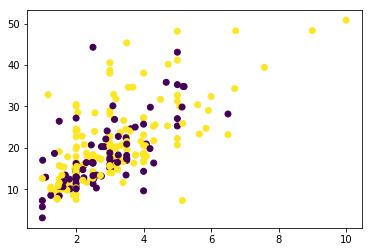

In [157]:
plt.scatter(tips.tip, tips.total_bill, c=tips.sex.cat.codes)
plt.show()

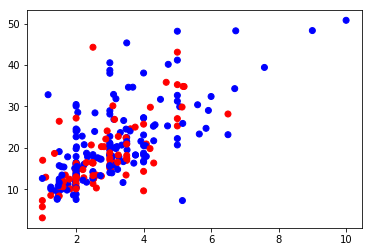

In [158]:
plt.scatter(tips.tip, tips.total_bill, c=np.array(["red", "blue"])[tips.sex.cat.codes])
plt.show()

# Index

In [159]:
x

      A      B    C
0  0.70  False    f
1  0.29  False  NaN
2  0.23   True    f
3  0.55  False    m
4  0.72   True    f

In [160]:
x.index

RangeIndex(start=0, stop=5, step=1)

In [161]:
x.columns

Index(['A', 'B', 'C'], dtype='object')

In [164]:
x.A.index # a Series object has one "index", inherited from data frame's .index

RangeIndex(start=0, stop=5, step=1)

In [163]:
x.A

0    0.70
1    0.29
2    0.23
3    0.55
4    0.72
Name: A, dtype: float64

In [165]:
x.index = pd.Index(["Mary", "Mark", "John", "Radko", "Raul"])
x

          A      B    C
Mary   0.70  False    f
Mark   0.29  False  NaN
John   0.23   True    f
Radko  0.55  False    m
Raul   0.72   True    f

In [166]:
x.index

Index(['Mary', 'Mark', 'John', 'Radko', 'Raul'], dtype='object')

In [167]:
x.A

Mary     0.70
Mark     0.29
John     0.23
Radko    0.55
Raul     0.72
Name: A, dtype: float64

In [170]:
x.set_index(np.r_[1,2,3,4,5]) # returns a copy

      A      B    C
1  0.70  False    f
2  0.29  False  NaN
3  0.23   True    f
4  0.55  False    m
5  0.72   True    f

In [172]:
x.reset_index()

   index     A      B    C
0   Mary  0.70  False    f
1   Mark  0.29  False  NaN
2   John  0.23   True    f
3  Radko  0.55  False    m
4   Raul  0.72   True    f

In [173]:
x.reset_index(drop=True)

      A      B    C
0  0.70  False    f
1  0.29  False  NaN
2  0.23   True    f
3  0.55  False    m
4  0.72   True    f

In [175]:
# "labels" can be named
x.index.name = "ROWS"
x.columns.name = "COLS"
x

COLS      A      B    C
ROWS                   
Mary   0.70  False    f
Mark   0.29  False  NaN
John   0.23   True    f
Radko  0.55  False    m
Raul   0.72   True    f

# Hierarchical Indexes

In [177]:
np.random.seed(123)
y = pd.DataFrame({"A": np.round(np.random.uniform(0,1,6),2)})
y

      A
0  0.70
1  0.29
2  0.23
3  0.55
4  0.72
5  0.42

In [178]:
y.index = pd.MultiIndex(
    names = ["top", "bottom"],
    levels = [ ["x", "y", "z"], [1,2,3,4] ],
    labels = [
        [0,0,0,1,1,2],
        [0,1,3,0,1,2]
    ]
)
y

               A
top bottom      
x   1       0.70
    2       0.29
    4       0.23
y   1       0.55
    2       0.72
z   3       0.42

In [180]:
tips.groupby(['sex', 'smoker', 'day']).mean()

                    total_bill       tip      size
sex    smoker day                                 
Female No     Fri    19.365000  3.125000  2.500000
              Sat    19.003846  2.724615  2.307692
              Sun    20.824286  3.329286  3.071429
              Thur   16.014400  2.459600  2.480000
       Yes    Fri    12.654286  2.682857  2.000000
              Sat    20.266667  2.868667  2.200000
              Sun    16.540000  3.500000  2.500000
              Thur   19.218571  2.990000  2.428571
Male   No     Fri    17.475000  2.500000  2.000000
              Sat    19.929063  3.256563  2.656250
              Sun    20.403256  3.115349  2.883721
              Thur   18.486500  2.941500  2.500000
       Yes    Fri    20.452500  2.741250  2.125000
              Sat    21.837778  2.879259  2.629630
              Sun    26.141333  3.521333  2.600000
              Thur   19.171000  3.058000  2.300000

In [181]:
tips.groupby(['sex', 'smoker', 'day']).mean().reset_index()

       sex smoker   day  total_bill       tip      size
0   Female     No   Fri   19.365000  3.125000  2.500000
1   Female     No   Sat   19.003846  2.724615  2.307692
2   Female     No   Sun   20.824286  3.329286  3.071429
3   Female     No  Thur   16.014400  2.459600  2.480000
4   Female    Yes   Fri   12.654286  2.682857  2.000000
5   Female    Yes   Sat   20.266667  2.868667  2.200000
6   Female    Yes   Sun   16.540000  3.500000  2.500000
7   Female    Yes  Thur   19.218571  2.990000  2.428571
8     Male     No   Fri   17.475000  2.500000  2.000000
9     Male     No   Sat   19.929063  3.256563  2.656250
10    Male     No   Sun   20.403256  3.115349  2.883721
11    Male     No  Thur   18.486500  2.941500  2.500000
12    Male    Yes   Fri   20.452500  2.741250  2.125000
13    Male    Yes   Sat   21.837778  2.879259  2.629630
14    Male    Yes   Sun   26.141333  3.521333  2.600000
15    Male    Yes  Thur   19.171000  3.058000  2.300000

In [182]:
flights = pd.read_csv("http://gagolewski.com/resources/data/flights.csv", comment="#")
flights.head(14)

    year      month  passengers
0   1949    January         112
1   1949   February         118
2   1949      March         132
3   1949      April         129
4   1949        May         121
5   1949       June         135
6   1949       July         148
7   1949     August         148
8   1949  September         136
9   1949    October         119
10  1949   November         104
11  1949   December         118
12  1950    January         115
13  1950   February         126

In [186]:
flights.set_index(['year', 'month']).head(14)

                passengers
year month                
1949 January           112
     February          118
     March             132
     April             129
     May               121
     June              135
     July              148
     August            148
     September         136
     October           119
     November          104
     December          118
1950 January           115
     February          126

In [185]:
flights.head()

   year     month  passengers
0  1949   January         112
1  1949  February         118
2  1949     March         132
3  1949     April         129
4  1949       May         121

In [187]:
# add column "date" - datetime64 (1949-01-whatever, ...)
flights["date"] = pd.to_datetime(
    flights.month.astype('str') + " " + flights.year.astype('str')
)
# set the new column to be an ".index"
flights = flights.set_index('date')

In [188]:
flights.head()

            year     month  passengers
date                                  
1949-01-01  1949   January         112
1949-02-01  1949  February         118
1949-03-01  1949     March         132
1949-04-01  1949     April         129
1949-05-01  1949       May         121

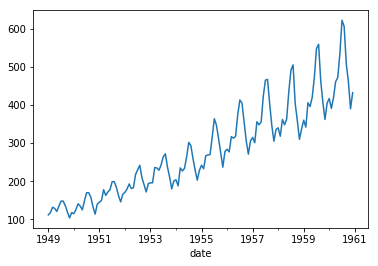

In [190]:
flights.passengers.plot()

# FILTERING

In [191]:
np.random.seed(123)
b = pd.Series(np.round(np.random.uniform(0,1,10),2))
c = b.copy()
c.index = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
b.index = np.random.permutation(np.r_[0:10])

In [192]:
b

2    0.70
1    0.29
8    0.23
7    0.55
9    0.72
4    0.42
5    0.98
6    0.68
3    0.48
0    0.39
dtype: float64

In [193]:
c

a    0.70
b    0.29
c    0.23
d    0.55
e    0.72
f    0.42
g    0.98
h    0.68
i    0.48
j    0.39
dtype: float64

**Never write `b[...]` or `c[....]`**

In [194]:
b[0:1]

2    0.7
dtype: float64

In [195]:
b[0]

0.39000000000000001

In [196]:
b[ [0] ]

0    0.39
dtype: float64

In [197]:
# b.iloc[...]  - positional
# b.loc[...]   - label-based

In [198]:
b.iloc[0]

0.69999999999999996

In [199]:
b.loc[0]

0.39000000000000001

In [200]:
b.values[0]

0.69999999999999996

In [202]:
c.loc["a"]

0.69999999999999996

In [203]:
c.iloc[0]

0.69999999999999996

In [204]:
c.loc[ "a":"d"] # inclusive

a    0.70
b    0.29
c    0.23
d    0.55
dtype: float64

In [205]:
b.loc[2:7]

2    0.70
1    0.29
8    0.23
7    0.55
dtype: float64

In [207]:
b.loc[7:2:-1]

7    0.55
8    0.23
1    0.29
2    0.70
dtype: float64

In [208]:
b.loc[ b > 0.7 ]

9    0.72
5    0.98
dtype: float64

In [209]:
b.loc[ [1,2,3]]

1    0.29
2    0.70
3    0.48
dtype: float64

In [212]:
birth_dates = birth_dates.set_index('BirthDate')
birth_dates.head()

                        Name
BirthDate                   
2000-06-12    Hung Hyun-Seok
1918-12-31  Benno Blumenthal
1958-06-26  Paitoon Ornwimol
1947-07-10    P'yon Yong-Sun
1983-09-04    Étienne Chaney

In [213]:
birth_dates.Name.loc["1918-12-31":"1925-01-01"]

BirthDate
1918-12-31      Benno Blumenthal
1921-12-19         Nedeljko Bukv
1923-03-30    Gordan Mislopoljac
1921-06-11      Eufebio Mascioli
1924-07-31         Sawa Mobumasu
1922-10-11       Nishioka Nissho
Name: Name, dtype: object

In [214]:
birth_dates.Name.loc["1918":"1925"]

BirthDate
1918-12-31      Benno Blumenthal
1921-12-19         Nedeljko Bukv
1923-03-30    Gordan Mislopoljac
1921-06-11      Eufebio Mascioli
1925-03-09         Onesto Nocera
1924-07-31         Sawa Mobumasu
1922-10-11       Nishioka Nissho
Name: Name, dtype: object

In [215]:
today = "2016-02-29" # arbitrary day
age   = 16 
# select names of people from birth_dates 
# and aged >= `age` as of `today`

In [216]:
# datetime.timedelta


In [219]:
import pandas.tseries.offsets
w = pd.to_datetime(today)-pandas.tseries.offsets.DateOffset(years=age)
birth_dates.Name.iloc[ birth_dates.index <= w].shape

(102,)

In [220]:
w

Timestamp('2000-02-29 00:00:00')

In [221]:
flights2 = flights.reset_index(drop=True).set_index(['year', 'month'])
flights2.head()

               passengers
year month               
1949 January          112
     February         118
     March            132
     April            129
     May              121

In [222]:
flights2.iloc[2]

passengers    132
Name: (1949, March), dtype: int64

In [223]:
flights2.iloc[2:5]

            passengers
year month            
1949 March         132
     April         129
     May           121

In [224]:
flights2.loc[1949]

           passengers
month                
January           112
February          118
March             132
April             129
May               121
June              135
July              148
August            148
September         136
October           119
November          104
December          118

In [226]:
flights2.loc[[1949,1959]]

                passengers
year month                
1949 January           112
     February          118
     March             132
     April             129
     May               121
     June              135
     July              148
     August            148
     September         136
     October           119
     November          104
     December          118
1959 January           360
     February          342
     March             406
     April             396
     May               420
     June              472
     July              548
     August            559
     September         463
     October           407
     November          362
     December          405

In [231]:
flights2.passengers.loc[:,"January"]

year
1949    112
1950    115
1951    145
1952    171
1953    196
1954    204
1955    242
1956    284
1957    315
1958    340
1959    360
1960    417
Name: passengers, dtype: int64

In [232]:
flights2.passengers.loc[ [(1949, "January"), (1954, "March")]]

year  month  
1949  January    112
1954  March      235
Name: passengers, dtype: int64

In [233]:
x

COLS      A      B    C
ROWS                   
Mary   0.70  False    f
Mark   0.29  False  NaN
John   0.23   True    f
Radko  0.55  False    m
Raul   0.72   True    f

In [234]:
x.iloc[2,2]

'f'

In [235]:
x.iloc[[1,3], :]

COLS      A      B    C
ROWS                   
Mark   0.29  False  NaN
Radko  0.55  False    m

In [236]:
x.iloc[[1,3], :].loc[:,["A", "C"]]

COLS      A    C
ROWS            
Mark   0.29  NaN
Radko  0.55    m

In [238]:
x.loc[x.A>0.5,:]

COLS      A      B  C
ROWS                 
Mary   0.70  False  f
Radko  0.55  False  m
Raul   0.72   True  f

In [239]:
tips.head()

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


1. get data on male customers only
2. choose male customers with total_bill in \$[10,20] 
3. choose Sat and Sun with tip > \$5
4. partition tips: create 2 df: tips_train (80%) and tips_test (20% rows)


In [240]:
#tips.loc[row_selector,column_selector]
#tips.iloc[row_selector,column_selector]
#row_selector can be a bool vector

In [242]:
tips.loc[tips.sex == 'Male',:].shape

(157, 7)

In [260]:
#tips.iloc[tips.sex == 'Male',:] doesn't work

In [263]:
#tips[tips.sex.values == "Male",:] doesn't work

In [248]:
tips.loc[tips.sex.values == "Male",:].shape, \
tips.iloc[tips.sex.values == "Male",:].shape

((157, 7), (157, 7))

In [249]:
x

COLS      A      B    C
ROWS                   
Mary   0.70  False    f
Mark   0.29  False  NaN
John   0.23   True    f
Radko  0.55  False    m
Raul   0.72   True    f

In [251]:
x.A > 0.5

ROWS
Mary      True
Mark     False
John     False
Radko     True
Raul      True
Name: A, dtype: bool

In [253]:
x.loc[x.A>0.5,:]

COLS      A      B  C
ROWS                 
Mary   0.70  False  f
Radko  0.55  False  m
Raul   0.72   True  f

In [254]:
x.loc[(x.A>0.5).sample(frac=1.0),:]

COLS      A      B  C
ROWS                 
Mary   0.70  False  f
Radko  0.55  False  m
Raul   0.72   True  f

In [258]:
u = (x.A>0.5).sample(frac=1.0)
u = u.loc[u]
u

ROWS
Radko    True
Mary     True
Raul     True
Name: A, dtype: bool

In [259]:
x.loc[u,:]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [265]:
tips.set_index('sex').loc['Male',:].reset_index().shape

(157, 7)

In [266]:
tips.query("sex == 'Male'").shape

(157, 7)

In [269]:
tips.query('10 <= total_bill <= 20 and sex == "Male"').shape

(76, 7)

In [270]:
tips.loc[(tips.sex=='Male') & (tips.total_bill>=10) & (tips.total_bill<=20),:].shape

(76, 7)

In [272]:
tips.loc[(tips.sex=='Male') & (tips.total_bill.between(10,20)),:].shape

(76, 7)

In [273]:
tips.query('day in ["Sat", "Sun"] and tip > 5').shape

(15, 7)

In [274]:
tips.loc[(tips.tip>5) & ((tips.day == "Sat") | (tips.day == "Sun")),:].shape

(15, 7)

In [275]:
tips.loc[(tips.tip>5) & (tips.day.isin(["Sat", "Sun"])),:].shape

(15, 7)

In [276]:
# partition
n = len(tips)
k = (8*n)//10
i = np.random.permutation(np.r_[[True]*k, [False]*(n-k)])
tips_train = tips.iloc[i,:]
tips_tips = tips.iloc[~i,:]

In [277]:
# sklearn train_test_split...
# random permutation of indexes - select (k) and (n-k)
tips2 = tips.sample(frac=1.0)
tips_train = tips.iloc[0:k,:]
tips_test = tips.iloc[k:,:]

In [279]:
tips_train = tips.sample(frac=0.8)
tips_test = tips.loc[~tips.index.isin(tips_train.index),:]

# operations on Series and DataFrames

In [280]:
x["A"]

ROWS
Mary     0.70
Mark     0.29
John     0.23
Radko    0.55
Raul     0.72
Name: A, dtype: float64

In [281]:
x["A"].values * x["A"].values

array([ 0.49  ,  0.0841,  0.0529,  0.3025,  0.5184])

In [282]:
x["A"] * x["A"]

ROWS
Mary     0.4900
Mark     0.0841
John     0.0529
Radko    0.3025
Raul     0.5184
Name: A, dtype: float64

In [283]:
x["A"] * x["A"].loc[["Mary", "Mark", "Mary"]]

ROWS
John        NaN
Mark     0.0841
Mary     0.4900
Mary     0.4900
Radko       NaN
Raul        NaN
Name: A, dtype: float64

In [284]:
a = pd.Series(["a", "b", "c"], index=[0,1,2])
a

0    a
1    b
2    c
dtype: object

In [287]:
b = pd.Series(["x", "y", "z"], index=[0,1,0])
b

0    x
1    y
0    z
dtype: object

In [288]:
a.loc[[0,0,1,1,2,2]] + b.loc[[1,1,1,2,2,0,0]]

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


0     ax
0     az
0     ax
0     az
0     ax
0     az
0     ax
0     az
1     by
1     by
1     by
1     by
1     by
1     by
2    NaN
2    NaN
2    NaN
2    NaN
dtype: object

In [289]:
np.sum(x.A)

2.4900000000000002

In [290]:
x.A.sum()

2.4900000000000002

In [291]:
x.A.median()

0.55

In [292]:
x.A.std()

0.22796929617823536

In [293]:
np.std(x.A, ddof=1)

0.22796929617823536

In [295]:
x.A.describe()

count    5.000000
mean     0.498000
std      0.227969
min      0.230000
25%      0.290000
50%      0.550000
75%      0.700000
max      0.720000
Name: A, dtype: float64

In [296]:
# pd.Series.mean
# pd.DataFrame.mean

x.mean()

COLS
A    0.498
B    0.400
dtype: float64

In [297]:
x

COLS      A      B    C
ROWS                   
Mary   0.70  False    f
Mark   0.29  False  NaN
John   0.23   True    f
Radko  0.55  False    m
Raul   0.72   True    f

In [298]:
x.describe()

COLS          A
count  5.000000
mean   0.498000
std    0.227969
min    0.230000
25%    0.290000
50%    0.550000
75%    0.700000
max    0.720000

In [301]:
x.describe(include='all')

COLS           A      B    C
count   5.000000      5    4
unique       NaN      2    2
top          NaN  False    f
freq         NaN      3    3
mean    0.498000    NaN  NaN
std     0.227969    NaN  NaN
min     0.230000    NaN  NaN
25%     0.290000    NaN  NaN
50%     0.550000    NaN  NaN
75%     0.700000    NaN  NaN
max     0.720000    NaN  NaN

In [303]:
tips.sex.value_counts()

Male      157
Female     87
Name: sex, dtype: int64

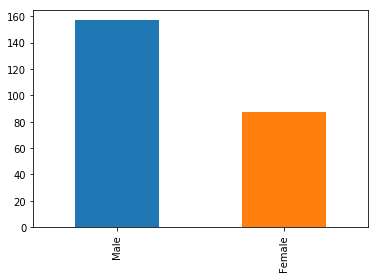

In [305]:
tips.sex.value_counts().plot(kind='bar')

In [306]:
pd.crosstab(tips.sex, tips.day)

day     Fri  Sat  Sun  Thur
sex                        
Female    9   28   18    32
Male     10   59   58    30

In [307]:
tips.groupby(["sex", "day"])

In [308]:
tips.groupby(["sex", "day"]).mean()

             total_bill       tip      size
sex    day                                 
Female Fri    14.145556  2.781111  2.111111
       Sat    19.680357  2.801786  2.250000
       Sun    19.872222  3.367222  2.944444
       Thur   16.715312  2.575625  2.468750
Male   Fri    19.857000  2.693000  2.100000
       Sat    20.802542  3.083898  2.644068
       Sun    21.887241  3.220345  2.810345
       Thur   18.714667  2.980333  2.433333

In [309]:
tips.groupby(["sex", "day"]).describe()

             size                                                 tip  \
            count      mean       std  min  25%  50%   75%  max count   
sex    day                                                              
Female Fri    9.0  2.111111  0.333333  2.0  2.0  2.0  2.00  3.0   9.0   
       Sat   28.0  2.250000  0.700529  1.0  2.0  2.0  2.25  4.0  28.0   
       Sun   18.0  2.944444  0.937595  2.0  2.0  3.0  3.75  5.0  18.0   
       Thur  32.0  2.468750  1.135480  1.0  2.0  2.0  2.00  6.0  32.0   
Male   Fri   10.0  2.100000  0.737865  1.0  2.0  2.0  2.00  4.0  10.0   
       Sat   59.0  2.644068  0.846142  2.0  2.0  2.0  3.00  5.0  59.0   
       Sun   58.0  2.810345  1.033762  2.0  2.0  2.0  4.00  6.0  58.0   
       Thur  30.0  2.433333  1.006302  2.0  2.0  2.0  2.00  6.0  30.0   

                       ...                  total_bill                        \
                 mean  ...       75%    max      count       mean        std   
sex    day             ...          

In [310]:
for e in tips.groupby("sex"):
    print(e)

('Female',      total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
11        35.26  5.00  Female     No   Sun  Dinner     4
14        14.83  3.02  Female     No   Sun  Dinner     2
16        10.33  1.67  Female     No   Sun  Dinner     3
18        16.97  3.50  Female     No   Sun  Dinner     3
21        20.29  2.75  Female     No   Sat  Dinner     2
22        15.77  2.23  Female     No   Sat  Dinner     2
29        19.65  3.00  Female     No   Sat  Dinner     2
32        15.06  3.00  Female     No   Sat  Dinner     2
33        20.69  2.45  Female     No   Sat  Dinner     4
37        16.93  3.07  Female     No   Sat  Dinner     3
51        10.29  2.60  Female     No   Sun  Dinner     2
52        34.81  5.20  Female     No   Sun  Dinner     4
57        26.41  1.50  Female     No   Sat  Dinner     2
66        16.45  2.47  Female     No   Sat  Dinner     2
67         3.07  1.0